Prepare state space trajectories for a lexical analysis.

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [61]:
from collections import Counter, defaultdict
import itertools
from pathlib import Path
import pickle
from typing import Any

import datasets
import matplotlib.pyplot as plt
from mne.decoding import ReceptiveField
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
import torch
import transformers
from tqdm.auto import tqdm

from src.analysis.state_space import StateSpaceAnalysisSpec
from src.models import get_best_checkpoint
from src.models.integrator import ContrastiveEmbeddingModel, load_or_compute_embeddings

In [4]:
model_dir = "outputs/models/w2v2_6_8/phoneme"
# model_checkpoint = "out/ce_model_phoneme_6_8/checkpoint-800"
# use a word-level equivalence dataset regardless of model, so that we can look up cohort facts
equiv_dataset_path = "data/timit_equivalence_facebook-wav2vec2-base_6-phoneme-1.pkl"
timit_corpus_path = "data/timit_syllables"

strffeat_path = "/userdata/jgauthier/ilina_timit/speech_analysis/out_sentence_details_timit_all_loudness.mat"
strffeat_extract_features = ["aud",
                            #  "F0",  # TODO copy over pitch analysis code
                             "maxDtL",
                             "phnfeatConsOnset",
                             "formantMedOnset"]

output_dir = "."

In [5]:
model = ContrastiveEmbeddingModel.from_pretrained(get_best_checkpoint(model_dir))
model.eval()

/home/jgauthier/u/transformers/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


ContrastiveEmbeddingModel(
  (rnn): RNNModel(
    (rnn): LSTM(768, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=8, bias=True)
  )
)

In [6]:
with open(equiv_dataset_path, "rb") as f:
    equiv_dataset = pickle.load(f)

In [7]:
model_representations = load_or_compute_embeddings(model, equiv_dataset, model_dir, equiv_dataset_path)

In [8]:
pca = PCA(2).fit(model_representations)
model_representations_pca = pca.transform(model_representations)

In [9]:
timit_corpus = datasets.load_from_disk(timit_corpus_path)["train"]

In [10]:
all_phonemes = set(equiv_dataset.class_labels)

In [11]:
cmudict_features = {
    "AA": "low back unrounded",
    "AE": "low front unrounded",
    "AH": "low central unrounded",
    "AO": "low back rounded",
    "AW": "mid back rounded",
    "AY": "high front unrounded",
    "B": "voiced bilabial plosive",
    "CH": "voiceless palato-alveolar affricate",
    "D": "voiced alveolar plosive",
    "DH": "voiced dental fricative",
    "EH": "mid front unrounded",
    "ER": "mid central unrounded",
    "EY": "mid front rounded",
    "F": "voiceless labiodental fricative",
    "G": "voiced velar plosive",
    "HH": "voiceless glottal fricative",
    "IH": "high front unrounded",
    "IY": "high front rounded",
    "JH": "voiced palato-alveolar affricate",
    "K": "voiceless velar plosive",
    "L": "voiced alveolar lateral approximant",
    "M": "voiced bilabial nasal",
    "N": "voiced alveolar nasal",
    "NG": "voiced velar nasal",
    "OW": "mid back rounded",
    "OY": "mid back rounded",
    "P": "voiceless bilabial plosive",
    "R": "voiced alveolar approximant",
    "S": "voiceless alveolar fricative",
    "SH": "voiceless palato-alveolar fricative",
    "T": "voiceless alveolar plosive",
    "TH": "voiceless dental fricative",
    "UH": "high back rounded",
    "UW": "high back rounded",
    "V": "voiced labiodental fricative",
    "W": "voiced labio-velar approximant",
    "Y": "voiced palatal approximant",
    "Z": "voiced alveolar fricative",
    "ZH": "voiced palato-alveolar fricative",
}
cmudict_features = {k: v.split() for k, v in cmudict_features.items()}

In [12]:
all_features = list(sorted(set(itertools.chain(*cmudict_features.values()))))
phon_feature2idx = {f: i for i, f in enumerate(all_features)}

In [13]:
cmudict_feature_idxs = {k: [phon_feature2idx[f] for f in v] for k, v in cmudict_features.items()}

In [14]:
phon_feature_to_phonemes = {f: [k for k, v in cmudict_features.items() if f in v] for f in all_features}

In [15]:
assert all(type(label) == str for label in equiv_dataset.class_labels), "Assumes dataset with phoneme labels"

## Prepare TIMIT features from STRF encoder

In [16]:
from scipy.io import loadmat

strffeat = loadmat(strffeat_path, simplify_cells=True)["sentdet"]
strffeat_all_names = [x["name"] for x in strffeat]

# Prepare a design matrix for each item, and ensure that its sampling rate
# matches that of the model representations.

In [17]:
# Prepare relevant feature shortnames
for trial in strffeat:
    trial["onset"] = trial["onsOff"][0]
    trial["offset"] = trial["onsOff"][1]

    trial["phnfeatConsOnset"] = trial["phnfeatonset"][[0, 1, 2, 7, 8, 10]]
    
    trial["maxDtL"] = trial["loudnessall"][5]

    # auditory and spectral features
    trial["aud"] = trial["aud"][:80]
    # trial["F0"] = trial["f0"][0]
    trial["formantMedOnset"] = trial["frmMedOns"][:4]

In [132]:
frames_by_item = equiv_dataset.hidden_state_dataset.frames_by_item

name_to_item_idx, name_to_frame_bounds, compression_ratios = {}, {}, {}
def process_item(item, idx):
    name = Path(item["file"]).parent.stem.lower() + "_" + item["id"].lower()
    if name in strffeat_all_names:
        name_to_item_idx[name] = idx

        frame_start, frame_end = equiv_dataset.hidden_state_dataset.frames_by_item[idx]
        name_to_frame_bounds[name] = (frame_start, frame_end)
        compression_ratios[name] = (frame_end - frame_start) / len(item["input_values"])
timit_corpus.map(process_item, with_indices=True)

item_idx_to_name = {v: k for k, v in name_to_item_idx.items()}

Map:   0%|          | 0/4620 [00:00<?, ? examples/s]

In [19]:
# Make sure that sentence features and model embeddings are of approximately the same length,
# modulo sampling differences. Compute length of each sentence in seconds according
# to two sources:
comparisons = [(strffeat_i["aud"].shape[1] / 100 - 1, # remove padding
                (name_to_frame_bounds[strffeat_i['name']][1] - name_to_frame_bounds[strffeat_i['name']][0]) / compression_ratios[strffeat_i["name"]] / 16000)
                for strffeat_i in strffeat if strffeat_i["name"] in name_to_frame_bounds]
np.testing.assert_allclose(*zip(*comparisons), atol=0.04,
                            err_msg="ECoG data and model embeddings should be of approximately the same length")

In [20]:
# Pre-compute the total number of features
strffeat_feature_names = []
for feature_set in strffeat_extract_features:
    feature_example = strffeat[0][feature_set]
    if feature_example.ndim == 2:
        strffeat_feature_names.extend([f"{feature_set}_{i}" for i in range(feature_example.shape[0])])
    else:
        strffeat_feature_names.append(feature_set)

strffeat_feature_dim = len(strffeat_feature_names)

In [63]:
from scipy.signal import resample

strffeat_feature_matrices: dict[int, np.ndarray] = {}
for trial_i in tqdm(strffeat):
    name = trial["name"]
    if name not in name_to_item_idx:
        continue

    frame_start, frame_end = name_to_frame_bounds[name]
    ret_features_i = np.zeros((strffeat_feature_dim, frame_end - frame_start))

    feature_offset = 0
    for feature_set in strffeat_extract_features:
        feature_ij = trial[feature_set]
        if feature_ij.ndim == 1:
            feature_ij = feature_ij[None, :]
        # feature_ij : (n_features, n_samples)

        # Trim padding
        before_pad, after_pad = trial["befaft"]
        before_pad = int(trial["dataf"] * before_pad)
        after_pad = int(trial["dataf"] * after_pad)
        feature_ij = feature_ij[:, before_pad:-after_pad]

        # Resample to match the model's sampling rate
        # If this is an onset feature, do this manually by visiting each nonzero
        # value and finding the corresponding frame
        is_onset_feature = set(itertools.chain.from_iterable(feature_ij.tolist())) == {0, 1}
        if is_onset_feature:
            for feature_idx, sample in zip(*feature_ij.nonzero()):
                # convert to model sample index
                sample = int(sample / trial["dataf"] * 16000 * compression_ratios[name])
                ret_features_i[feature_offset + feature_idx, sample] = 1.
        else:
            for feature_idx in range(feature_ij.shape[0]):
                ret_features_i[feature_offset + feature_idx] = \
                    resample(feature_ij[feature_idx], frame_end - frame_start)

        feature_offset += feature_ij.shape[0]

    strffeat_feature_matrices[name_to_item_idx[name]] = ret_features_i

  0%|          | 0/499 [00:00<?, ?it/s]

In [42]:
# name_to_item_idx["mzmb0_si1796"]
# np.array(timit_corpus[1133]["phonemic_detail"]["start"]) / 16000

array([0.1425   , 0.1775   , 0.2375   , 0.2898125, 0.3078125, 0.5925   ,
       0.6775   , 0.7625   , 0.9675   , 1.01     , 1.0481875, 1.1925   ,
       1.2975   , 1.3375   , 1.4625   , 1.6025   , 1.6425   ])

## Prepare design matrix

In [139]:
feature_names = ["onset_item", "onset_word", "onset_phoneme"]

use_strffeat_features = False
if use_strffeat_features:
    feature_names += strffeat_feature_names
else:
    feature_names += list(phon_feature_to_phonemes.keys())

feature2idx = {name: i for i, name in enumerate(feature_names)}
design_matrix = np.zeros((model_representations.shape[0], len(feature_names)))
fit_mask = np.ones(model_representations.shape[0], dtype=bool)

def update_design_matrix(item, idx):
    start_frame, end_frame = frames_by_item[idx]
    num_frames = end_frame - start_frame
    compression_ratio = num_frames / len(item["input_values"])

    design_matrix[start_frame, feature2idx["onset_item"]] = 1.

    if use_strffeat_features and idx not in strffeat_feature_matrices:
        fit_mask[start_frame:end_frame] = False
        return

    for word in item["word_phonemic_detail"]:
        if len(word) == 0:
            continue

        word_start = start_frame + int(word[0]["start"] * compression_ratio)
        design_matrix[word_start, feature2idx["onset_word"]] = 1.

        for phoneme in word:
            phoneme_start = start_frame + int(phoneme["start"] * compression_ratio)
            design_matrix[phoneme_start, feature2idx["onset_phoneme"]] = 1.

            if not use_strffeat_features:
                for feature in cmudict_features[phoneme["phone"]]:
                    design_matrix[phoneme_start, feature2idx[feature]] = 1.

    if use_strffeat_features:
        for strffeat_feature_idx, feature_name in enumerate(strffeat_feature_names):
            design_matrix[start_frame:end_frame, feature2idx[feature_name]] = \
                strffeat_feature_matrices[idx][strffeat_feature_idx]

timit_corpus.map(update_design_matrix, with_indices=True)

Map:   0%|          | 0/4620 [00:00<?, ? examples/s]

Dataset({
    features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id', 'word_phonetic_detail', 'input_values', 'phone_targets', 'phonemic_detail', 'word_phonemic_detail', 'word_syllable_detail'],
    num_rows: 4620
})

In [140]:
from src.analysis.trf import estimate_trf_cv

In [141]:
trf_df = estimate_trf_cv(design_matrix,
                         model_representations,
                         [str(idx) for idx in range(model_representations.shape[1])],
                         feature_names=feature_names, tmin=-1, tmax=5, sfreq=1,
                         n_splits=3)

Fitting 1 epochs, 94 channels


  0%|          | Sample : 0/4559 [00:00<?,       ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/analysis/trf.py:34: RuntimeWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  trf.fit(X[train_idx], y[train_idx])


Fitting 1 epochs, 94 channels


  0%|          | Sample : 0/4559 [00:00<?,       ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/analysis/trf.py:34: RuntimeWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  trf.fit(X[train_idx], y[train_idx])


Fitting 1 epochs, 94 channels


  0%|          | Sample : 0/4559 [00:00<?,       ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/analysis/trf.py:34: RuntimeWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  trf.fit(X[train_idx], y[train_idx])


In [142]:
trf_df

,fold,level_1,feature,output_name,input_dim,output_dim,lag,time,coef
0,0,0,onset_item,0,0,0,-1,-1.0,0.023311
1,0,1,onset_item,0,0,0,0,0.0,0.028647
2,0,2,onset_item,0,0,0,1,1.0,0.028952
3,0,3,onset_item,0,0,0,2,2.0,0.025248
4,0,4,onset_item,0,0,0,3,3.0,0.020307
...,...,...,...,...,...,...,...,...,...
15787,2,5259,formantMedOnset_3,7,93,7,1,1.0,-0.063432
15788,2,5260,formantMedOnset_3,7,93,7,2,2.0,-0.102691
15789,2,5261,formantMedOnset_3,7,93,7,3,3.0,-0.013907
15790,2,5262,formantMedOnset_3,7,93,7,4,4.0,-0.655132


In [147]:
largest_coefs = trf_df.groupby(["feature"]).apply(lambda xs: xs.groupby("output_name").coef.apply(np.linalg.norm).agg(["idxmax", "max"])).sort_values("max").iloc[-30:]
largest_coefs

coef,idxmax,max
feature,,
onset_item,3,0.221990
maxDtL,2,3.957915
formantMedOnset_2,3,5.963440
formantMedOnset_3,3,9.684771
formantMedOnset_1,2,13.880162
formantMedOnset_0,2,22.733917
phnfeatConsOnset_0,2,69.218816
phnfeatConsOnset_5,2,75.353523
phnfeatConsOnset_1,2,149.474960


In [148]:
highlight_df = pd.merge(trf_df, largest_coefs.reset_index(),
                        left_on=["feature", "output_name"], right_on=["feature", "idxmax"])

In [149]:
# baseline by pre-onset activation
highlight_df = pd.merge(highlight_df, highlight_df.groupby(["feature", "output_name", "fold"]).apply(lambda xs: xs[xs.lag <= 0].coef.mean()).rename("baseline"),
                        left_on=["feature", "output_name", "fold"], right_index=True)
highlight_df["coef_baselined"] = highlight_df["coef"] - highlight_df["baseline"]
highlight_df["feature"] = highlight_df.feature.astype(str)

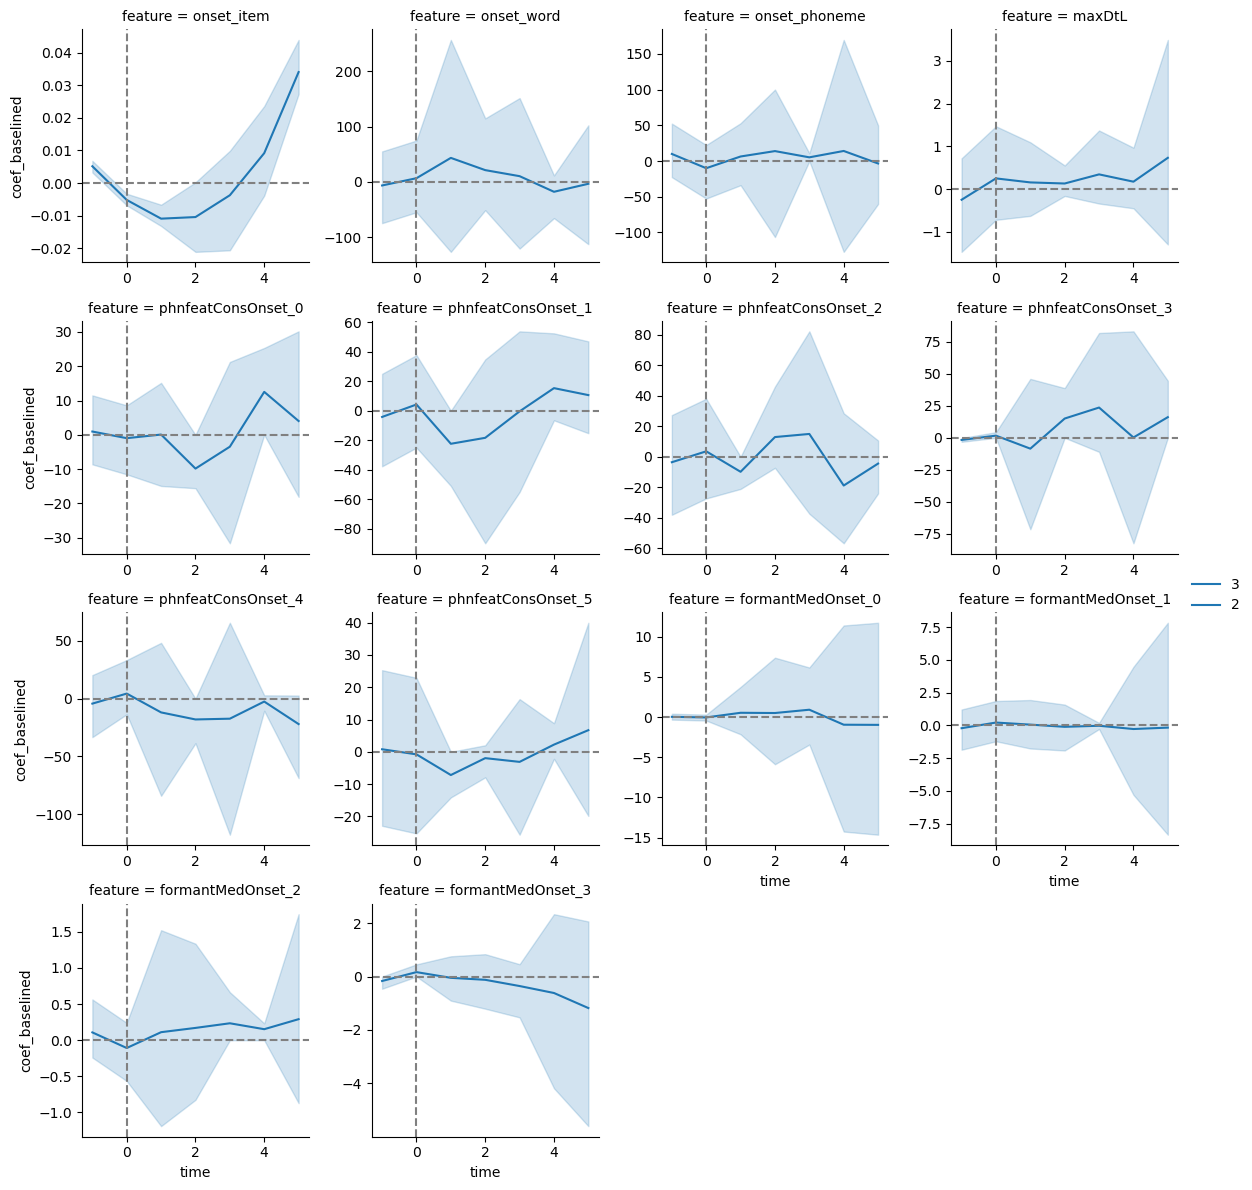

In [150]:
g = sns.FacetGrid(highlight_df, col="feature", col_wrap=4,
                  hue_order=sorted(highlight_df.output_name.unique()),
                  sharex=False, sharey=False)
g.map(sns.lineplot, "time", "coef_baselined", "output_name")
g.add_legend()

for ax in g.axes.flat:
    ax.axhline(0, color="gray", linestyle="--")
    ax.axvline(0, color="gray", linestyle="--")

In [ ]:
trf_df.to_csv(Path(output_dir) / "trf_df.csv", index=False)